<a href="https://colab.research.google.com/github/JulioLaz/001-angular/blob/main/Consumer_Spending_Prediction_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**PROBLEMA DE NEGOCIO**


---




La necesidad de prever y optimizar el gasto de sus usuarios ha llevado a una empresa de comercio electrónico a buscar soluciones innovadoras. Como científicos de datos, hemos sido convocados para desarrollar un modelo de machine learning que pueda predecir con precisión cuánto gastará un usuario al visitar dicho sitio web.

### **Tus tareas principales serán:**

**1. Preprocesamiento de Datos:** Importar correctamente y analizar y comprender el conjunto de datos proporcionado, realizar limpieza de datos, eliminar atributos que no aportan valor y manejar valores faltantes.

**2. Exploración y Feature Engineering:** Realizar visualizaciones para entender las relaciones entre las variables y seleccionar las características relevantes, identificar variables llaves, codificación de variables categóricas y normalización/escalado de datos.

**3. Construcción de Modelos:** Experimentar con algunos algoritmos de machine learning como Linear Regression, Decision Tree Regressor, Random Forest Regressor, entre otros.

**4. Evaluación y Selección del Modelo:** Evaluar los modelos utilizando métricas como el error cuadrático medio (MSE), la raíz cuadrada del error cuadrático medio (RMSE) y el coeficiente de determinación (R²). Seleccionar el modelo con el mejor rendimiento para la predicción del gasto de los usuarios.

## Referencia de las variables:
https://support.google.com/analytics/answer/3437719?hl=es-419

#**1. Configuración del Ambiente**


---




In [81]:
# !python -V
# print('------')
# !pip show Pandas | grep 'Name\|Version'
# print('------')
# !pip show Matplotlib | grep 'Name\|Version'

# Python 3.10.12
# ------
# Name: pandas
# Version: 1.5.3
# ------
# Name: matplotlib
# Version: 3.7.1

In [82]:
!pip install xgboost

In [83]:
!pip install wget

In [84]:
import wget
import warnings
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb

from scipy.stats import randint
from sklearn.preprocessing import LabelEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from joblib import dump, load

# Ignorar las advertencias
warnings.filterwarnings("ignore")

# Configurar pandas para mostrar todas las columnas
pd.set_option('display.max_columns', None)

# Variables globales
global df_traffic, resultados, modelo, modelo_clasificacion


#**2. Preprocesamiento de Datos**


---


In [85]:
### Browser con valores not NaN y que son >0:
# result = df_traffic.groupby('browser')['transactionRevenue'].apply(lambda x: x.notna().sum()).reset_index(name='count_non_na')
# result[result['count_non_na']>0]

In [86]:
def preprocesamiento():
  global df_traffic
  df_traffic = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/traffic_site.csv', dtype={'date':object,'fullVisitorId':object,'visitId':object})
  diccionarios = ['device','geoNetwork','trafficSource','totals']

  ## Desempacar diccionario:
  for columna in diccionarios:
    df_traffic = df_traffic.join(pd.DataFrame([json.loads(linea) for linea in df_traffic[columna]]))
  df_traffic.drop(columns=diccionarios, axis=1,inplace=True)

  # Convertir las columnas a string para envitar error:
  df_traffic_str = df_traffic.astype(str).copy()

  # Buscar las columnas que tienen un sólo valor:
  unique_value=[]
  for col in df_traffic_str.drop(columns='isMobile',axis=1).columns:
      if 1 == len(df_traffic_str[col].unique()):
        unique_value.append(col)
  print(f'Vars con valor único ({len(unique_value)})\n {unique_value}')

  ### eliminar col con valor único:
  df_traffic.drop(columns=unique_value,axis=1,inplace=True)

  ## Elimino columna con valor un sólo valor
  df_traffic.drop(columns='campaignCode',axis=1,inplace=True)

  ### cambiar columnas a tipo número:
  cuant = ['fullVisitorId','visitId','visitNumber','visitStartTime', 'bounces', 'hits','pageviews','newVisits','pageviews', 'transactionRevenue']
  for columna in cuant:
      df_traffic[columna] = pd.to_numeric(df_traffic[columna])

# ///////////////////////////////////////////////////////////////////////////

  ### Analizar si hay alguna tipo dict:
  for col in df_traffic.columns:
    if isinstance(df_traffic[col].iloc[0], dict):
        print(f"La columna '{col}' contiene valores de tipo dict.")

  ### cambiar valor dentro del dict anterior:
  df_traffic['adwordsClickInfo'] = df_traffic['adwordsClickInfo'].apply(lambda x: np.nan if isinstance(x, dict) and x == {'criteriaParameters': 'not available in demo dataset'} else x)

  ### Desempacar del dict clave valor:
  # Aplicar pd.Series() a la columna 'adwordsClickInfo' para dividir los diccionarios en columnas
  expanded_info = df_traffic['adwordsClickInfo'].apply(pd.Series)

  # Concatenar el DataFrame original con las nuevas columnas
  df_traffic = pd.concat([df_traffic, expanded_info], axis=1)

  # Eliminar la columnas:
  columns_to_drop = ['adwordsClickInfo', 'criteriaParameters', 0, 'targetingCriteria', 'date']
  df_traffic.drop(columns=columns_to_drop, inplace=True)

  df_traffic = df_traffic.drop_duplicates() ##eliminar filas duplicadas
# ///////////////////////////////////////////////////////////////////////////

  ## Cambio formato a visitStartTime:
  df_traffic['visitStartTime'] = pd.to_datetime(df_traffic['visitStartTime'], unit='s')

  ### cambia los nan a ceros:
  df_traffic.fillna(0, inplace=True)

  ### Dividir el target en 1e6:
  df_traffic['transactionRevenue']= df_traffic['transactionRevenue']/1e6
  df_traffic.head(5)

preprocesamiento()

Vars con valor único (18)
 ['socialEngagementType', 'browserVersion', 'browserSize', 'operatingSystemVersion', 'mobileDeviceBranding', 'mobileDeviceModel', 'mobileInputSelector', 'mobileDeviceInfo', 'mobileDeviceMarketingName', 'flashVersion', 'language', 'screenColors', 'screenResolution', 'cityId', 'latitude', 'longitude', 'networkLocation', 'visits']
La columna 'adwordsClickInfo' contiene valores de tipo dict.


#**3. Exploración y Feature Engineering**


---


In [87]:
def feature_engineering():
    global df_traffic
    ### Descomponer la columna visitStartTime en columns: año, mes, semana, quincena:
    df_traffic['visitStartTime'] = pd.to_datetime(df_traffic['visitStartTime'])

    # Crear columnas para el año, el mes, la semana del mes, la quincena del mes y la hora
    df_traffic['year'] = df_traffic['visitStartTime'].dt.year.astype('uint16')
    df_traffic['month'] = df_traffic['visitStartTime'].dt.month.astype('uint8')
    df_traffic['fortnight'] = df_traffic['visitStartTime'].dt.day.apply(lambda day: 1 if day <= 15 else 2).astype('uint8')
    df_traffic['hour'] = df_traffic['visitStartTime'].dt.hour.astype('uint8')
    df_traffic['day'] = df_traffic['visitStartTime'].dt.day.astype('uint8')
    df_traffic['time_range'] = pd.cut(df_traffic['visitStartTime'].dt.hour, bins=[0, 6, 12, 18, 24], labels=['madrugada', 'mañana', 'tarde', 'noche'], ordered=False).astype('object')

    ## Elimino col visitStartTime:
    df_traffic.drop(columns='visitStartTime', axis=1,inplace=True)

    ### Aplicar Codificador de etiquetas para transformar de cualitativa a cuantitativa ordinal:
    cualitativas = df_traffic.dtypes[df_traffic.dtypes == object].keys()
    for columna in cualitativas:
        lbl = LabelEncoder()
        strings = list(df_traffic[columna].values.astype('str'))
        lbl.fit(strings)
        df_traffic[columna] = lbl.transform(strings)
        # Convertir al tipo uint8
        df_traffic[columna] = df_traffic[columna].astype('uint8')

    ## Elimino col sessionId:
    df_traffic.drop(columns='sessionId',inplace=True)

    ## Codificación de frecuencia:
    ### Codificación de Frecuencia:  para fullVisitorId:
    fullVisitorId_frequency = df_traffic['fullVisitorId'].value_counts()
    df_traffic['fullVisitorId_enc_frec'] = df_traffic['fullVisitorId'].map(fullVisitorId_frequency)

    ### Codificación de Frecuencia:  para visitId:
    fullVisitorId_frequency = df_traffic['visitId'].value_counts()
    df_traffic['visitId_enc_frec'] = df_traffic['visitId'].map(fullVisitorId_frequency)

    ### Eliminar visitId, fullVisitorId:
    df_traffic.drop(columns='visitId',axis=1,inplace=True)
    df_traffic.drop(columns='fullVisitorId',axis=1,inplace=True)

    ## convertir a int la col booleana:
    df_traffic['isMobile'] = df_traffic['isMobile'].astype(int)

    ## cambiar los nan por ceros:
    df_traffic.fillna(0, inplace=True)

    # Rellenar los valores faltantes en 'transactionRevenue' con cero
    df_traffic['transactionRevenue'].fillna(0, inplace=True)

    ## Crear nueva col con clasificacion de 0 y 1 para transactionRevenue:
    df_traffic['revenue_zero'] = np.where(df_traffic['transactionRevenue'] == 0, 1, 0)

    # Codificación one-hot y eliminación de columnas originales
    columns=['browser', 'continent','networkDomain']
    df_traffic = pd.get_dummies(df_traffic, columns=columns, prefix=columns, drop_first=True)

    ### cambiar a frecuencias:
    columns_to_map = ['city', 'country', 'subContinent', 'metro','hour','time_range','channelGrouping']

    for column in columns_to_map:
        column_frequency = df_traffic[column].value_counts()
        df_traffic[column] = df_traffic[column].map(column_frequency)

    #### Eliminar columnas;
    columns_features= ['year','fortnight','isMobile','campaign','gclId',
                       'page', 'adContent','bounces','newVisits',
                       'metro','visitId_enc_frec','browser_1','browser_2',
                      'browser_3',	'browser_4',	'browser_6',	'browser_7'] ### ,'gclId','page'
    for feature in columns_features:
        df_traffic.drop(columns=[feature], inplace=True)

    df_traffic.drop(columns=['isVideoAd', 'adNetworkType','slot','hits'],axis=1,inplace=True)

    ### optimize memory
    conversion_dict = {
        'transactionRevenue': 'uint16',
        'channelGrouping': 'uint16',
        'subContinent': 'uint16',
        'country': 'uint16',
        'city': 'uint16',
        'hour': 'uint16',
        'time_range': 'uint16',
        'fullVisitorId_enc_frec': 'uint8',
        'visitNumber': 'uint8',
        'revenue_zero': 'uint8',
        'pageviews': 'uint16'
    }
    df_traffic = df_traffic.astype(conversion_dict)

    # df_traffic['visitId_enc_frec'] = df_traffic['visitId_enc_frec'].astype('uint8')
    # df_traffic['newVisits'] = df_traffic['newVisits'].astype('uint8')
    # df_traffic['bounces'] = df_traffic['bounces'].astype('uint8')
    # df_traffic['isMobile'] = df_traffic['isMobile'].astype('uint8')


feature_engineering()

In [88]:
columnas_int = df_traffic.dtypes[df_traffic.dtypes == 'int64'].index.tolist()
df_traffic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12283 entries, 0 to 12282
Columns: 296 entries, channelGrouping to networkDomain_255
dtypes: uint16(8), uint8(288)
memory usage: 3.7 MB


In [89]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, classification_report
# import numpy as np

# # Paso 2: División de datos
# X = df_traffic.drop(columns='transactionRevenue', axis=1)
# y = df_traffic['transactionRevenue']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# # Supongamos que df_traffic es tu DataFrame que contiene los datos

# # Paso 1: Preprocesar los datos
# # Rellenar los valores faltantes en 'transactionRevenue' con cero
# df_traffic['transactionRevenue'].fillna(0, inplace=True)

# # Crear una nueva columna que indique si 'transactionRevenue' es cero o no
# df_traffic['revenue_zero'] = np.where(df_traffic['transactionRevenue'] == 0, 1, 0)

# # Paso 2: Dividir los datos en conjuntos de entrenamiento y prueba
# X = df_traffic.drop(['transactionRevenue', 'revenue_zero'], axis=1)  # Características
# y = df_traffic['revenue_zero']  # Etiqueta

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Paso 3: Ajustar el modelo de regresión logística
# log_reg = LogisticRegression()
# log_reg.fit(X_train, y_train)

# # Paso 4: Evaluar el modelo
# y_pred = log_reg.predict(X_test)

# # Calcular la precisión del modelo
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

# # Mostrar el informe de clasificación
# # print("\nClassification Report:")
# # print(classification_report(y_test, y_pred))

# from sklearn.metrics import r2_score, mean_squared_error

# # Calcular R^2
# r2 = r2_score(y_test, y_pred)
# print("R^2 Score:", r2)

# # Calcular RMSE
# rmse = mean_squared_error(y_test, y_pred, squared=False)
# print("RMSE:", rmse)

# # pd.DataFrame(y_pred)[0].value_counts()


In [90]:
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import mean_squared_error,r2_score
# from sklearn.ensemble import GradientBoostingRegressor

# # Paso 1: Preprocesamiento de datos si es necesario

# # Paso 2: División de datos
# X = df_traffic.drop(columns='transactionRevenue', axis=1)
# y = df_traffic['transactionRevenue']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Paso 3: Modelo de regresión logística para clasificación binaria
# model_binaria = LogisticRegression()
# model_binaria.fit(X_train, y_train.apply(lambda x: 1 if x > 0 else 0))  # Clasificación binaria

# # Paso 4: Modelo para valores distintos de cero
# X_revenue = X_train[model_binaria.predict(X_train) == 1]  # Filtrar las observaciones con clasificación distinta de cero
# y_revenue = y_train[y_train.index.isin(X_revenue.index)]  # Etiquetas correspondientes
# model_gamma = GradientBoostingRegressor()  # Por ejemplo, puedes usar un modelo Gradient Boosting para valores distintos de cero
# model_gamma.fit(X_revenue, y_revenue)

# # Paso 5: Predicción de valores de 'transactionRevenue'
# X_test_revenue = X_test[model_binaria.predict(X_test) == 1]  # Filtrar las observaciones con clasificación distinta de cero
# y_pred_revenue = model_gamma.predict(X_test_revenue)

# # Combinar las predicciones para obtener las predicciones finales de 'transactionRevenue'
# y_pred_final = pd.Series(index=X_test.index)
# y_pred_final[y_pred_final.index.isin(X_test_revenue.index)] = y_pred_revenue
# y_pred_final[y_pred_final.index.difference(X_test_revenue.index)] = 0  # Asignar cero a las predicciones clasificadas como cero

# # Evaluar el rendimiento
# rmse = mean_squared_error(y_test, y_pred_final, squared=False)
# print("RMSE:", rmse)
# r2 = r2_score(y_test, y_pred_final)
# print("R^2 Score:", r2)


### Graf scatter de transactionRevenue: Selección sólo de valores > 0

In [91]:
# plt.figure(figsize=(6, 4))
# plt.scatter(range(len(df_traffic['transactionRevenue'])), df_traffic['transactionRevenue'], alpha=.4, s=10)
# plt.title('Gráfico de Dispersión de transactionRevenue')
# plt.ylabel('transactionRevenue')

# # Ocultar los ticks del eje x
# plt.xticks([])

# # Agregar el texto con la cantidad de puntos
# cantidad_nan = df_traffic['transactionRevenue'].isna().sum()
# num_points = len(df_traffic['transactionRevenue'])
# plt.text(num_points/3, (df_traffic['transactionRevenue'].max())*1.05, f'Cantidad de muestras: {num_points-cantidad_nan}', fontsize=8, color='navy')
# plt.ylim(-.5e8,8.5e8)
# plt.show()

### Graf scatter de transactionRevenue: todos los valores del dataset

### Cambiar valores nan por ceros:

In [92]:
# plt.figure(figsize=(6, 4))
# plt.scatter(range(len(df_traffic['transactionRevenue'])), df_traffic['transactionRevenue'], alpha=.4, s=10)
# plt.title('Gráfico de Dispersión de transactionRevenue')
# plt.ylabel('transactionRevenue')

# # Ocultar los ticks del eje x
# plt.xticks([])

# # Agregar el texto con la cantidad de puntos
# cantidad_nan = df_traffic['transactionRevenue'].isna().sum()
# num_points = len(df_traffic['transactionRevenue'])
# plt.text(num_points/3, (df_traffic['transactionRevenue'].max())*1.05, f'Cantidad de muestras: {num_points-cantidad_nan}', fontsize=8, color='navy')
# plt.ylim(-.5e8,8.5e8)
# plt.show()

### Graf boxplot de transactionRevenue: selección de valores > 0

In [93]:
# valores_mayores_que_cero = df_traffic[df_traffic['transactionRevenue'] > 0]['transactionRevenue']
# sns.boxplot(valores_mayores_que_cero)

### Graf boxplot de transactionRevenue: todos los valores del dataset

In [94]:
# valores_mayores_que_cero = df_traffic[df_traffic['transactionRevenue'] > 0]['transactionRevenue']
# sns.boxplot(df_traffic['transactionRevenue'])

In [95]:
#Histograma (antes)
# ax = sns.histplot(data=df_traffic, x='transactionRevenue', kde=False)
# ax.set_title('Histograma de transactionRevenue')
# ax.set_xlabel('transactionRevenue');

## Guardar dataset:

In [96]:
# df_traffic.to_csv('/content/drive/MyDrive/Consumer_Spending_Prediction/dataset.csv', index=False)

In [97]:
# plt.figure(figsize=(30, 10))
# heatmap = sns.heatmap(df_traffic.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
# heatmap.tick_params(axis='both', which='major', labelsize=14)
# plt.title('Mapa de Calor de Correlaciones', fontsize=18)
# plt.show()

In [98]:
# correlation_matrix = df_traffic.corr()

# # Encontrar las características con correlación mayor a 0.99
# high_correlation_features = set()  # Conjunto para almacenar las características con alta correlación

# for i in range(len(correlation_matrix.columns)):
#     for j in range(i):
#         if abs(correlation_matrix.iloc[i, j]) > 0.99:  # Verificar si la correlación es mayor a 0.99
#             # Agregar las características a high_correlation_features
#             feature_i = correlation_matrix.columns[i]
#             feature_j = correlation_matrix.columns[j]
#             high_correlation_features.add(feature_i)
#             high_correlation_features.add(feature_j)

# # Imprimir las características con alta correlación
# print("Características con correlación mayor a 0.99:")

# serie_high_correlation_features=[]
# for i in high_correlation_features:
#     serie_high_correlation_features.append(i)


# serie_high_correlation_features

### eliminar las de corr >99%

In [99]:
# df_traffic.drop(columns=['isVideoAd', 'adNetworkType','slot','hits'],axis=1,inplace=True)
# df_traffic.info()

In [100]:
# plt.figure(figsize=(30, 10))
# heatmap = sns.heatmap(df_traffic.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
# heatmap.tick_params(axis='both', which='major', labelsize=14)
# plt.title('Mapa de Calor de Correlaciones', fontsize=18)
# plt.show()

In [101]:
# correlacion=df_traffic.corr()

# correlacion_mayor_target = abs(correlacion['transactionRevenue'])
# df_corr_all = correlacion_mayor_target.sort_values(ascending=False)
# df_corr_all = pd.DataFrame(df_corr_all)
# df_corr_all.reset_index(inplace=True)
# df_corr_all.columns = ['Feature', 'Correlation']

# # Ajusta el tamaño de la gráfica y utiliza la paleta 'inferno'
# plt.figure(figsize=(12, 8))
# colors = sns.color_palette('Blues_r', len(df_corr_all['Correlation']))

# # Crea la gráfica de barras horizontales
# bars = plt.barh(df_corr_all['Feature'], df_corr_all['Correlation'], color=colors, edgecolor='gray')

# # Agrega etiquetas con porcentajes al final de las barras
# for bar, value in zip(bars, df_corr_all['Correlation']):
#       if value!=0:
#           plt.text(value, bar.get_y() + bar.get_height() / 2, f'  {value:.2%} ',ha='left', va='center', color='darkblue', fontsize=9,fontweight='bold')

# plt.xscale('log')  # Configura la escala logarítmica en el eje x
# plt.xlabel('Correlación con transactionRevenue (escala logarítmica)',)
# plt.title('Correlación de las variables vs Default', fontsize=20,fontweight='bold',color='darkblue')
# plt.gca().invert_yaxis()  # Invierte el eje y para mostrar de mayor a menor


# plt.xticks([])
# plt.yticks(fontsize=8)
# plt.box(False)
# plt.grid(False)
# plt.show()

#**4. Construcción de Modelos**


---


In [102]:
def crea_modelos():

    data_traf=df_traffic.copy()
    X = data_traf.drop('transactionRevenue',axis=1)
    y = data_traf.transactionRevenue.copy()

    ### Separar en bases de entrenamiento y prueba:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)

    # Crea una instancia de StandardScaler
    scaler = StandardScaler()

    # Ajusta el escalador a tus datos de entrenamiento
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    ### MODELS  ###
    #  RandomForestRegressor
    #  LGBMRegressor
    #  XGBRegressor
    #  XGB

    random_forest_regressor = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=10, min_samples_leaf=4)
    lgbm_regressor = LGBMRegressor(n_estimators=165, max_depth=10, learning_rate=0.1, min_child_samples=10)
    xgb_regressor = XGBRegressor(n_estimators=140, max_depth=10, learning_rate=0.1, min_child_weight=10)

    # Entrenar los modelos con los datos
    random_forest_regressor.fit(X_train_scaled, y_train)
    lgbm_regressor.fit(X_train, y_train)
    xgb_regressor.fit(X_train, y_train)

    # Hacer predicciones con los modelos entrenados
    y_pred_random_forest = random_forest_regressor.predict(X_test_scaled)
    y_pred_lgbm = lgbm_regressor.predict(X_test)
    y_pred_xgb = xgb_regressor.predict(X_test)

    # Evaluar los modelos
    rmse_random_forest = mean_squared_error(y_test, y_pred_random_forest, squared=False)
    rmse_lgbm = mean_squared_error(y_test, y_pred_lgbm, squared=False)
    rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)

    r2_random_forest = r2_score(y_test, y_pred_random_forest)
    r2_lgbm = r2_score(y_test, y_pred_lgbm)
    r2_xgb = r2_score(y_test, y_pred_xgb)

    ################################################################
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Definir los parámetros del modelo
    params_xgb = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 6,
        'eta': 0.05,
        'subsample': 0.91,
        'colsample_bytree': 0.81,
        'seed': 42
    }

    # Entrenar el modelo
    num_round = 900  # Número de iteraciones
    bst = xgb.train(params_xgb, dtrain, num_round, evals=[(dtest, 'eval')], early_stopping_rounds=18)

    # Hacer predicciones en el conjunto de prueba
    y_pred = bst.predict(dtest)

    # Evaluar el modelo
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    ################################################################
    print("Resultados de los Modelos Adicionales:")
    print(f"Random Forest Regressor - R-cuadrado (R²): {r2_random_forest:.2%}, RMSE: {rmse_random_forest:.2f}")
    print(f"LightGBM Regressor - R-cuadrado (R²): {r2_lgbm:.2%}, RMSE: {rmse_lgbm:.2f}")
    print(f"XGBoost Regressor - R-cuadrado (R²): {r2_xgb:.2%}, RMSE: {rmse_xgb:.2f}")
    print(f"XGB - R-cuadrado (R²): {r2:.2%}, RMSE: {rmse:.2f}")

In [103]:
crea_modelos()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 9826, number of used features: 204
[LightGBM] [Info] Start training from score 1.480256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

In [104]:
def crea_modelos_others():
    data_traf = df_traffic.copy()
    X = data_traf.drop('transactionRevenue', axis=1)
    y = data_traf.transactionRevenue.copy()

    # Separar en bases de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    # Escalar los datos
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Inicializar y entrenar modelos
    models = {
        "RandomForestRegressor": RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=10, min_samples_leaf=4),
        "LGBMRegressor": LGBMRegressor(n_estimators=165, max_depth=10, learning_rate=0.1, min_child_samples=10),
        "XGBRegressor": XGBRegressor(n_estimators=140, max_depth=10, learning_rate=0.1, min_child_weight=10),
        "XGB": xgb.XGBRegressor(
            objective='reg:squarederror',
            eval_metric='rmse',
            max_depth=10,
            eta=0.1,
            min_child_weight=10,
            subsample=0.91,
            colsample_bytree=0.81,
            seed=42
        )
    }
    params_xgb = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 6,
        'eta': 0.05,
        'subsample': 0.91,
        'colsample_bytree': 0.8,
        'seed': 42
    }
    results = {}

    for model_name, model in models.items():
        if model_name != "XGB":
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
        else:
            dtrain = xgb.DMatrix(X_train, label=y_train)
            dtest = xgb.DMatrix(X_test, label=y_test)
            num_round = 900
            bst = xgb.train(params_xgb, dtrain, num_round, evals=[(dtest, 'eval')], early_stopping_rounds=18)
            y_pred = bst.predict(dtest)

        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)
        results[model_name] = (r2, rmse)

    # Print results
    print("Resultados de los modelos:")
    for model_name, (r2, rmse) in results.items():
        print(f"{model_name}: R² = {r2:.2%}, RMSE = {rmse:.2f}")


In [105]:
crea_modelos_others()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1210
[LightGBM] [Info] Number of data points in the train set: 9826, number of used features: 204
[LightGBM] [Info] Start training from score 1.480256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

In [106]:
### posicion de la columna transactionRevenue:
# numero_posicion = data_traf.columns.get_loc('transactionRevenue')
# print(numero_posicion)

In [107]:
from sklearn.model_selection import cross_val_score

def modelos_final():

    global df_metrics
    data_traf = df_traffic.copy()
    X = data_traf.drop('transactionRevenue', axis=1)
    y = data_traf.transactionRevenue.copy()

    # Separar en bases de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    # Escalar los datos
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    random_forest_regressor = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=10, min_samples_leaf=4)
    lgbm_regressor = LGBMRegressor(n_estimators=200, max_depth=10, learning_rate=0.1, min_child_samples=10)
    xgb_regressor = XGBRegressor(n_estimators=200, max_depth=10, learning_rate=0.1, min_child_weight=10)

    # Entrenar y evaluar modelos de manera independiente
    random_forest_regressor.fit(X_train_scaled, y_train)
    lgbm_regressor.fit(X_train, y_train)
    xgb_regressor.fit(X_train, y_train)

    y_pred_random_forest = random_forest_regressor.predict(X_test_scaled)
    y_pred_lgbm = lgbm_regressor.predict(X_test)
    y_pred_xgb = xgb_regressor.predict(X_test)

    rmse_random_forest = mean_squared_error(y_test, y_pred_random_forest, squared=False)
    rmse_lgbm = mean_squared_error(y_test, y_pred_lgbm, squared=False)
    rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)

    r2_random_forest = r2_score(y_test, y_pred_random_forest)
    r2_lgbm = r2_score(y_test, y_pred_lgbm)
    r2_xgb = r2_score(y_test, y_pred_xgb)

    params_xgb_dmatrix = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 10,
        'eta': 0.1,
        'subsample': 0.91,
        'colsample_bytree': 0.8,
        'seed': 42
    }

    params_xgb = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 6,
        'eta': 0.05,
        'subsample': 0.91,
        'colsample_bytree': 0.8,
        'seed': 42
    }
############################################
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    bst = xgb.train(params_xgb, dtrain, 900, evals=[(dtest, 'eval')], early_stopping_rounds=18)
    y_pred_xgb = bst.predict(dtest)
    r2_XGB = r2_score(y_test, y_pred_xgb)
    rmse_XGB = mean_squared_error(y_test, y_pred_xgb, squared=False)
############################################

    # Realizar validación cruzada para XGBoost
    dall = xgb.DMatrix(X, label=y)
    cv_results = xgb.cv(params_xgb_dmatrix, dall, num_boost_round=1000, nfold=5, metrics='rmse', early_stopping_rounds=10, seed=42)
    best_num_round = cv_results['test-rmse-mean'].idxmin()
    bst_new = xgb.train(params_xgb_dmatrix, dall, num_boost_round=best_num_round)
    y_pred_new = bst_new.predict(xgb.DMatrix(X_test))

    rmse_new = mean_squared_error(y_test, y_pred_new, squared=False)
    r2_new = r2_score(y_test, y_pred_new)

    # Imprimir resultados
    # print("Resultados de los Modelos Adicionales:")
    # print(f"Random Forest Regressor - R²: {r2_random_forest:.2%}, RMSE: {rmse_random_forest:.2f}")
    # print(f"LightGBM Regressor - R²: {r2_lgbm:.2%}, RMSE: {rmse_lgbm:.2f}")
    # print(f"XGBoost Regressor - R²: {r2_xgb:.2%}, RMSE: {rmse_xgb:.2f}")
    # print(f"XGB - R²: {r2_XGB:.2%}, RMSE: {rmse_XGB:.2f}")
    # print(f"XGB DMatrix - R²: {r2_new:.2%}, RMSE: {rmse_new:.2f}")

    model_metrics = {
    "Random Forest Regressor": {"R2": r2_random_forest, "RMSE": rmse_random_forest},
    "LightGBM Regressor": {"R2": r2_lgbm, "RMSE": rmse_lgbm},
    "XGBoost Regressor": {"R2": r2_xgb, "RMSE": rmse_xgb},
    "XGB": {"R2": r2_XGB, "RMSE": rmse_XGB},
    "XGB DMatrix": {"R2": r2_new, "RMSE": rmse_new}
    }
    df_model_metrics = pd.DataFrame(model_metrics).T
    df_metrics=df_model_metrics.round(4)
    return  df_metrics
modelos_final()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 9826, number of used features: 204
[LightGBM] [Info] Start training from score 1.480256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

,R2,RMSE
Random Forest Regressor,0.5585,13.7461
LightGBM Regressor,0.6514,12.2156
XGBoost Regressor,0.6985,11.3596
XGB,0.7198,10.9513
XGB DMatrix,0.9998,0.2896


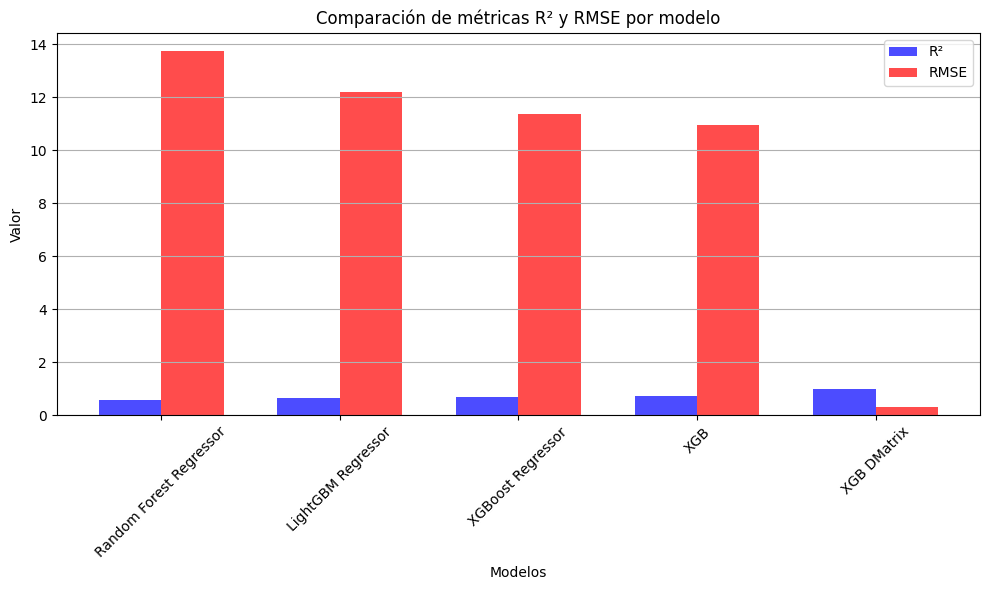

In [108]:
import numpy as np
import matplotlib.pyplot as plt

df=df_metrics

model_names = df.index
r2_values = df.R2
rmse_values = df.RMSE

# Configuración de posiciones de barras
bar_width = 0.35
index = np.arange(len(model_names))

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
bar1 = plt.bar(index, r2_values, bar_width, color='b', alpha=0.7, label='R²')
bar2 = plt.bar(index + bar_width, rmse_values, bar_width, color='r', alpha=0.7, label='RMSE')

# Añadir etiquetas y título
plt.xlabel('Modelos')
plt.ylabel('Valor')
plt.title('Comparación de métricas R² y RMSE por modelo')
plt.xticks(index + bar_width / 2, model_names, rotation=45)
plt.legend()

# Mostrar el gráfico
plt.grid(axis='y')
plt.tight_layout()
plt.show()


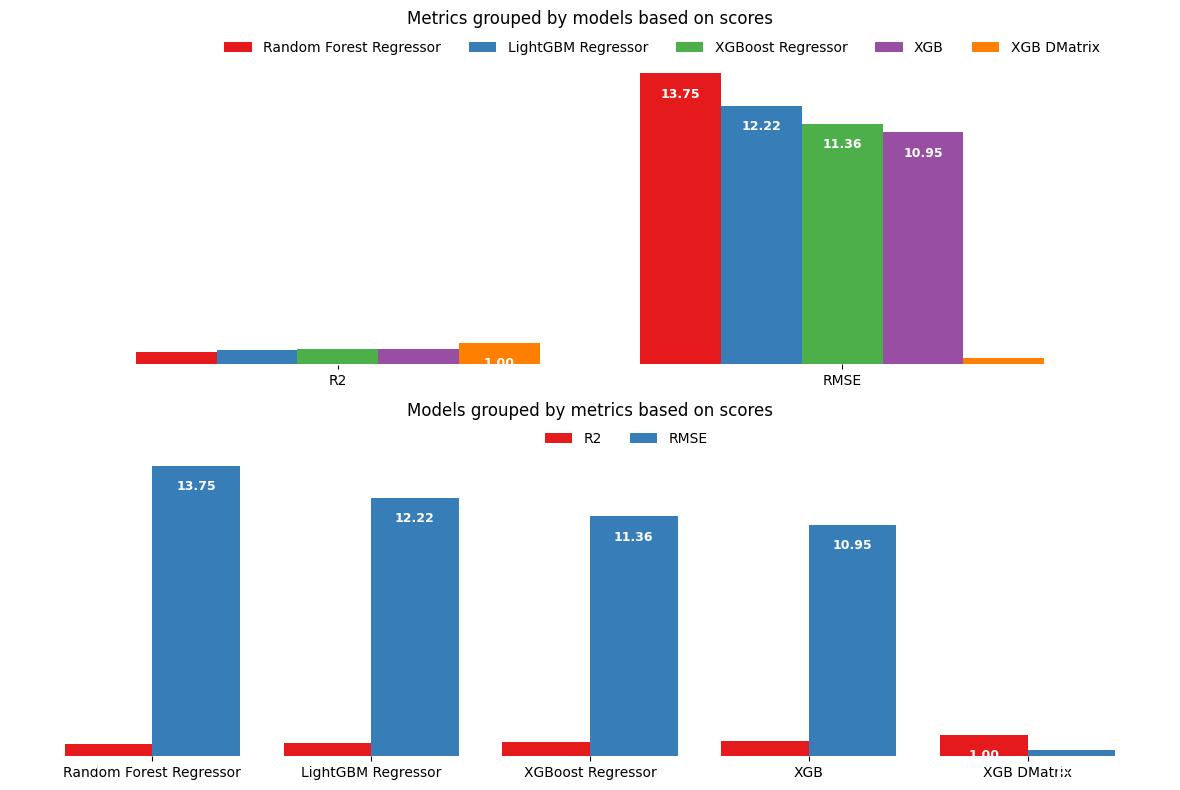

In [109]:
def graf_models_vs_metrics(df):
    # Crear una figura y ejes
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    sns.set_palette('Set1')

    # Gráfica de barras: Modelos en función de las Métricas
    def add_values(ax):
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', xytext=(0, -15), textcoords='offset points',fontsize=9,color='white',fontweight='bold')
    df.T.plot(kind='bar', ax=ax[0], rot=0, width=0.8)
    ax[0].set_title('Metrics grouped by models based on scores',pad=25)

    # Configuraciones para la primera figura
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['bottom'].set_visible(False)
    ax[0].spines['left'].set_visible(False)
    ax[0].grid(False)
    ax[0].set_yticks([])
    ax[0].legend(title='', bbox_to_anchor=(.95, 1.1), frameon=False, fontsize=10, ncol=len(df.T.columns))
    # ax[0].legend()

    # Agregar valores a la primera gráfica
    add_values(ax[0])

    # Gráfica de barras: Métricas en función de los Modelos
    df.plot(kind='bar', ax=ax[1], rot=0, width=0.8)
    ax[1].set_title('Models grouped by metrics based on scores',pad=25)

    # Configuraciones para la segunda figura
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['bottom'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].grid(False)
    ax[1].set_yticks([])
    ax[1].set_xlabel('')
    ax[1].legend(title='', loc='center left', bbox_to_anchor=(.45, 1.04), frameon=False, fontsize=10, ncol=len(df.columns))
    ax[1].set_ylabel('')

    # Agregar valores a la segunda gráfica
    add_values(ax[1])
    plt.tight_layout()
    plt.show()
graf_models_vs_metrics(df_metrics)

In [110]:
modelos_new()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 9826, number of used features: 204
[LightGBM] [Info] Start training from score 1.480256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

In [111]:
### MODELS  ###
#  RandomForestRegressor
#  LGBMRegressor
#  XGBRegressor
#  XGB

random_forest_regressor = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=10, min_samples_leaf=4)
lgbm_regressor = LGBMRegressor(n_estimators=165, max_depth=10, learning_rate=0.1, min_child_samples=10)
xgb_regressor = XGBRegressor(n_estimators=140, max_depth=10, learning_rate=0.1, min_child_weight=10)

# Entrenar los modelos con los datos
random_forest_regressor.fit(X_train_scaled, y_train)
lgbm_regressor.fit(X_train, y_train)
xgb_regressor.fit(X_train, y_train)

# Hacer predicciones con los modelos entrenados
y_pred_random_forest = random_forest_regressor.predict(X_test_scaled)
y_pred_lgbm = lgbm_regressor.predict(X_test)
y_pred_xgb = xgb_regressor.predict(X_test)

# Evaluar los modelos
rmse_random_forest = mean_squared_error(y_test, y_pred_random_forest, squared=False)
rmse_lgbm = mean_squared_error(y_test, y_pred_lgbm, squared=False)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)

r2_random_forest = r2_score(y_test, y_pred_random_forest)
r2_lgbm = r2_score(y_test, y_pred_lgbm)
r2_xgb = r2_score(y_test, y_pred_xgb)

################################################################

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Definir los parámetros del modelo
params_xgb = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'eta': 0.05,
    'subsample': 0.91,
    'colsample_bytree': 0.81,
    'seed': 42
}


# Entrenar el modelo
num_round = 900  # Número de iteraciones
bst = xgb.train(params_xgb, dtrain, num_round, evals=[(dtest, 'eval')], early_stopping_rounds=18)

# Hacer predicciones en el conjunto de prueba
y_pred = bst.predict(dtest)

# Evaluar el modelo
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"R-cuadrado (R²): {r2:.2%}")
print(f"RMSE: {rmse:.2f}")

################################################################

print("Resultados de los Modelos Adicionales:")
print(f"Random Forest Regressor - R-cuadrado (R²): {r2_random_forest:.2%}, RMSE: {rmse_random_forest:.2f}")
print(f"LightGBM Regressor - R-cuadrado (R²): {r2_lgbm:.2%}, RMSE: {rmse_lgbm:.2f}")
print(f"XGBoost Regressor - R-cuadrado (R²): {r2_xgb:.2%}, RMSE: {rmse_xgb:.2f}")
print(f"XGB - R-cuadrado (R²): {r2:.2%}, RMSE: {rmse_xgb:.2f}")

# XGBoost - R-cuadrado (R²): 75.55%, RMSE: 10.23  ///11.54 //4.32%, RMSE: 11.11  rfr:13.79

NameError: name 'X_train_scaled' is not defined

In [ ]:
modelos_proba()

In [ ]:
def model_xgb_dmatrix(df_traffic):
    # Preparar los datos
    X = df_traffic.drop('transactionRevenue', axis=1)
    y = df_traffic['transactionRevenue']

    # Separar en conjunto de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Definir los parámetros del modelo XGBoost
    params_xgb = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 10,
        'eta': 0.1,
        'subsample': 0.91,
        'colsample_bytree': 0.8,
        'seed': 42
    }

    # Crear objeto DMatrix para todos los datos
    dall = xgb.DMatrix(X, label=y)

    # Realizar validación cruzada para evaluar el rendimiento del modelo
    cv_results = xgb.cv(params_xgb, dall, num_boost_round=1000, nfold=5, metrics='rmse', early_stopping_rounds=10, seed=42)

    # Seleccionar el número óptimo de rondas de entrenamiento
    best_num_round = cv_results['test-rmse-mean'].idxmin()

    # Entrenar el modelo con el número óptimo de rondas
    bst = xgb.train(params_xgb, dall, num_boost_round=best_num_round)

    # Realizar predicciones en el conjunto de prueba
    y_pred = bst.predict(xgb.DMatrix(X_test))

    df_traffic_zero_up = df_traffic[df_traffic['transactionRevenue'] > 0]
    X_zero_up= df_traffic_zero_up.drop(columns='transactionRevenue',axis=1,inplace=True)

    df_traffic_zero = df_traffic[df_traffic['transactionRevenue'] == 0]
    X_zero= df_traffic_zero.drop(columns='transactionRevenue',axis=1,inplace=True)

    # y_pred_zero_up = bst.predict(xgb.DMatrix(X_zero_up))
    y_pred_total = bst.predict(xgb.DMatrix(X))

    # Evaluar el modelo
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    print(f"R²: {r2:.2%}, RMSE: {rmse:.2f}")

model_xgb_dmatrix(df_traffic)


In [ ]:
def model_lgb(df_traffic):

    features = df_traffic.drop('transactionRevenue',axis=1)
    target = df_traffic.transactionRevenue.copy()
    # Dividir los datos en conjunto de entrenamiento y conjunto de prueba
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    # Crear un objeto Dataset de LightGBM
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)

    # Definir los parámetros del modelo
    params = {
        'objective': 'regression',
        'metric': 'rmse',  # Métrica de evaluación: Error cuadrático medio
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0
    }

    # Entrenar el modelo
    num_round = 1000  # Número de iteraciones
    bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

    # Hacer predicciones en el conjunto de prueba
    y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

    # Evaluar el modelo
    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    print(f"RMSE: {rmse}")
    from sklearn.metrics import r2_score

    # Calcular el coeficiente de determinación (R-cuadrado)
    r2 = r2_score(y_test, y_pred)
    print(f"R-cuadrado (R²): {r2}")

model_lgb(df_traffic)

In [ ]:
def crea_modelos_new():
    data_traf = df_traffic.copy()
    X = data_traf.drop('transactionRevenue', axis=1)
    y = data_traf.transactionRevenue.copy()

    # Separar en bases de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    # Escalar los datos
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Inicializar y entrenar modelos
    models = {
        "RandomForestRegressor": RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=10, min_samples_leaf=4),
        "LGBMRegressor": LGBMRegressor(n_estimators=165, max_depth=10, learning_rate=0.1, min_child_samples=10),
        "XGBRegressor": XGBRegressor(n_estimators=140, max_depth=10, learning_rate=0.1, min_child_weight=10),
        "XGB": xgb.XGBRegressor(
    objective= 'reg:squarederror',
    eval_metric= 'rmse',
    max_depth= 6,
    eta= 0.05,
    subsample= 0.91,
    colsample_bytree= 0.81,
    seed= 42
        )
    }

    # Parámetros para el nuevo modelo XGB
    params_xgb = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 10,
        'eta': 0.1,
        'subsample': 0.91,
        'colsample_bytree': 0.8,
        'seed': 42
    }

    # Crear objeto DMatrix para todos los datos
    dall = xgb.DMatrix(X, label=y)

    # Realizar validación cruzada para evaluar el rendimiento del modelo XGB
    cv_results = xgb.cv(params_xgb, dall, num_boost_round=1000, nfold=5, metrics='rmse', early_stopping_rounds=10, seed=42)

    # Seleccionar el número óptimo de rondas de entrenamiento para el nuevo modelo XGB
    best_num_round = cv_results['test-rmse-mean'].idxmin()

    # Entrenar el modelo XGB con el número óptimo de rondas
    bst = xgb.train(params_xgb, dall, num_boost_round=best_num_round)

    # Realizar predicciones en el conjunto de prueba para el nuevo modelo XGB
    y_pred_xgb = bst.predict(xgb.DMatrix(X_test))

    # Evaluar el modelo XGB
    rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
    r2_xgb = r2_score(y_test, y_pred_xgb)

    results = {}

    for model_name, model in models.items():
        if model_name != "XGB":
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
        else:
            dtrain = xgb.DMatrix(X_train, label=y_train)
            dtest = xgb.DMatrix(X_test, label=y_test)
            num_round = 900
            bst = xgb.train(params_xgb, dtrain, num_round, evals=[(dtest, 'eval')], early_stopping_rounds=18)
            y_pred = bst.predict(dtest)

        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)
        results[model_name] = (r2, rmse)

    # Agregar resultados para el nuevo modelo XGB
    results["XGB_new"] = (r2_xgb, rmse_xgb)

    # Imprimir resultados
    print("Resultados de los modelos:")
    for model_name, (r2, rmse) in results.items():
        print(f"{model_name}: R² = {r2:.2%}, RMSE = {rmse:.2f}")

crea_modelos_new()

In [ ]:
# crea_modelos()
for i, model in enumerate(resultados['Model']):
    print('-------------------------------')
    print(f"Modelo: {model}")
    print(f"R-cuadrado (R²): {resultados['R2'][i]}")
    print(f"Error cuadrático medio (MSE): {resultados['MSE'][i]}")
    print(f"Raíz del error cuadrático medio (RMSE): {resultados['RMSE'][i]}")
    print('-------------------------------')

#**5. Evaluación y Selección del Modelo**


---


In [ ]:
visualiza_resultados()

#**6. Producción**


---


In [ ]:
#Cargar base de prueba y ejecutar normalización utilizada en nuestro modelo
df_traffic = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/traffic_test.csv', dtype={'date':object,'fullVisitorId':object,'visitId':object})
preprocesamiento()
feature_engineering()

#Cargar el modelo entrenado
wget.download('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/modelo.joblib', 'modelo.joblib')
modelo = load('modelo.joblib')
wget.download('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/modelo_clasificacion.joblib', 'modelo_clasificacion.joblib')
modelo_clasificacion = load('modelo_clasificacion.joblib')

#Pronosticar con la nueva base
X = df_traffic.drop('transactionRevenue',axis=1)
X['clasificacion'] = modelo_clasificacion.predict(X)
y = df_traffic.transactionRevenue.copy()
predictions = modelo.predict(xgb.DMatrix(X))
predictions[predictions < 1] = 0

#Genera algunas métricas de evaluación de los pronosticos
r2 = r2_score(y, predictions)*100
mse = mean_squared_error(y, predictions)
rmse = np.sqrt(mse)
print(f"R-cuadrado (R²): {r2}")
print(f"Error cuadrático medio (MSE): {mse}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse}")

In [ ]:
#Ejemplos de los pronósticos
df_resultados = pd.DataFrame({
    'transactionRevenue': y,
    'predictions': predictions
})
df_resultados[df_resultados.transactionRevenue>0].sample(10)